<a href="https://colab.research.google.com/github/raulbs7/Machine-Learning-Techniques-Project/blob/master/Dengue_Supervised_Project/2_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Baseline

At this part, the goal will be to investigate what type of regression algorithm give us better results to, after that, make an optimization of his parameters.


## 2.1  Initialization

First of all, it is going to be imported all the Python libraries normally used in data science. Also, it will be imported the datasets.

In [1]:
# data load and manipulation
from google.colab import files
from google.colab import drive
import io
# dataframes library
import pandas as pd
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# basic operations
import numpy as np
# cross validation
from sklearn.model_selection import KFold
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression
# regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
# metrics 
from sklearn.metrics import mean_absolute_error

This function is used por obtain a dataframe from a csv file, in which we can determine the columns we want.

In [2]:
def upload_files (index_fields):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    return df

Importing the preprocessed train and test dataset.

In [3]:
train = upload_files([])
train.head()

Saving processed_train.csv to processed_train.csv
User uploaded file "processed_train.csv" with length 304080 bytes


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_iq,city_sj
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0,1
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0,1
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,0,1
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,0,1
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,0,1


In [4]:
test = upload_files([])
test.head()

Saving processed_test.csv to processed_test.csv
User uploaded file "processed_test.csv" with length 85026 bytes


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city_iq,city_sj
0,2008,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0,1
1,2008,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0,1
2,2008,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,0,1
3,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,0,1
4,2008,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,0,1


## 2.2 Analysis of data

The train data is already preprocessed and there is not any null value. 

In [5]:
pd.isnull(train).any()

year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

This dataset has many variables, so it is recommended, in order to train a model with less time, the reduction of some features can improve the model's performance, due to the addition of noise that can perjudicate the predictions.

---
Before this project, another investigation was done interpreting the data, and applying to it unsupervised learning techniques, which provides very useful information.
By doing hierarchical clustering to this dataset, it was seen that there are some important variables that could represent each family of clusters:

* ``reanalysis_relative_humidity_percent``
* ``reanalysis_air_temp_k``
* ``station_avg_temp_c``
* ``year``
* ``reanalysis_tdtr_k``

Also, there is going to be added other important features such as ``weekofyear`` and the preprocessed columns ``city_sj`` and ``city_iq``, very determinant because they are differents cities with independent data.

In [71]:
selected_features = ['reanalysis_relative_humidity_percent', 
                'reanalysis_air_temp_k', 'station_avg_temp_c', 'reanalysis_tdtr_k',
                'year', 'weekofyear', 'city_sj', 'city_iq']

In [59]:
X_train = train[selected_features]
X_test = test[selected_features]
y_train = train['total_cases']

## 2.3 Random Forests


In [42]:
cv = KFold(n_splits = 10, shuffle = False)

In [74]:
fold_mae = []

for train_fold, test_fold in cv.split(sj_train):
  # Random division of the train set to do cross validation
  f_train_X = sj_train.iloc[train_fold]
  f_test_X = sj_train.iloc[test_fold]
  f_train_y = sj_train['total_cases'].iloc[train_fold]
  f_test_y = sj_train['total_cases'].iloc[test_fold]
  # FIT THE MODEL
  f_model = RandomForestRegressor().fit(f_train_X.drop(['total_cases'], axis = 1), f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X.drop(['total_cases'], axis = 1))
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Random Forest implementation: ', forest_mae)

Estimated MAE of Random Forest implementation:  29.25413097689316


In [60]:
fold_mae = []

for train_fold, test_fold in cv.split(X_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train.iloc[train_fold]
  f_test_X = X_train.iloc[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = RandomForestRegressor().fit(f_train_X, f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X)
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Random Forest implementation: ', forest_mae)

Estimated MAE of Random Forest implementation:  19.44668545111006


## 2.4 Linear Regression

In [31]:
fold_mae = []

for train_fold, test_fold in cv.split(train):
  # Random division of the train set to do cross validation
  f_train_X = train.iloc[train_fold]
  f_test_X = train.iloc[test_fold]
  f_train_y = train['total_cases'].iloc[train_fold]
  f_test_y = train['total_cases'].iloc[test_fold]
  # FIT THE MODEL
  f_model = LinearRegression().fit(f_train_X.drop(['total_cases'], axis = 1), f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X.drop(['total_cases'], axis = 1))
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Linear Regression implementation: ', forest_mae)

Estimated MAE of Linear Regression implementation:  22.959775887170146


In [32]:
fold_mae = []

for train_fold, test_fold in cv.split(X_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train.iloc[train_fold]
  f_test_X = X_train.iloc[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = LinearRegression().fit(f_train_X, f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X)
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Linear Regression implementation: ', forest_mae)

Estimated MAE of Linear Regression implementation:  21.352600988566884


## 2.5 Decision Tree

In [33]:
fold_mae = []

for train_fold, test_fold in cv.split(train):
  # Random division of the train set to do cross validation
  f_train_X = train.iloc[train_fold]
  f_test_X = train.iloc[test_fold]
  f_train_y = train['total_cases'].iloc[train_fold]
  f_test_y = train['total_cases'].iloc[test_fold]
  # FIT THE MODEL
  f_model = DecisionTreeRegressor().fit(f_train_X.drop(['total_cases'], axis = 1), f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X.drop(['total_cases'], axis = 1))
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Decision Tree implementation: ', forest_mae)

Estimated MAE of Decision Tree implementation:  21.80616910722721


In [34]:
fold_mae = []

for train_fold, test_fold in cv.split(X_train):
  # Random division of the train set to do cross validation
  f_train_X = X_train.iloc[train_fold]
  f_test_X = X_train.iloc[test_fold]
  f_train_y = y_train.iloc[train_fold]
  f_test_y = y_train.iloc[test_fold]
  # FIT THE MODEL
  f_model = DecisionTreeRegressor().fit(f_train_X, f_train_y)
  # PREDICT AND SCORE
  y_pred = f_model.predict(X = f_test_X)
  mae = mean_absolute_error(f_test_y, y_pred)
  fold_mae.append(mae)
forest_mae = sum(fold_mae)/len(fold_mae)

print('Estimated MAE of Decision Tree implementation: ', forest_mae)

Estimated MAE of Decision Tree implementation:  21.728885214926784


## 2.6 K-nearest-neighbors

Min Value uniform : 21.73666731501292 (17)
Min Value distance : 21.540520713376328 (17)


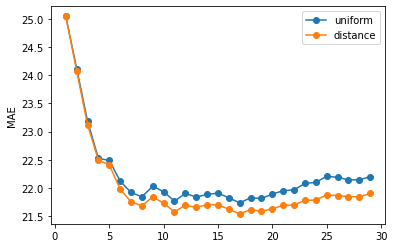

In [35]:
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_mae = []
       knn = KNeighborsRegressor(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(X_train):
         # Random division of the train set to do cross validation
         f_train_X = train.iloc[train_fold]
         f_test_X = train.iloc[test_fold]
         f_train_y = train['total_cases'].iloc[train_fold]
         f_test_y = train['total_cases'].iloc[test_fold]
         # FIT THE MODEL
         f_model = knn.fit(f_train_X.drop(['total_cases'], axis = 1), f_train_y)
         # PREDICT AND SCORE
         y_pred = f_model.predict(X = f_test_X.drop(['total_cases'], axis = 1))
         mae = mean_absolute_error(f_test_y, y_pred)
         fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show()

Min Value uniform : 18.989030523877005 (21)
Min Value distance : 18.97300726520404 (21)


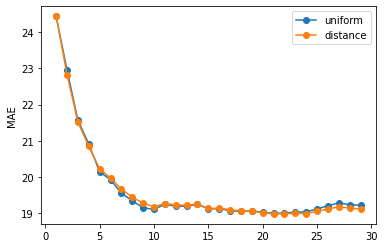

In [36]:
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_mae = []
       knn = KNeighborsRegressor(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(X_train):
         # Random division of the train set to do cross validation
         f_train_X = X_train.iloc[train_fold]
         f_test_X = X_train.iloc[test_fold]
         f_train_y = y_train.iloc[train_fold]
         f_test_y = y_train.iloc[test_fold]
         # FIT THE MODEL
         f_model = knn.fit(f_train_X, f_train_y)
         # PREDICT AND SCORE
         y_pred = f_model.predict(X = f_test_X)
         mae = mean_absolute_error(f_test_y, y_pred)
         fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show()